<a href="https://colab.research.google.com/github/mysujan/MLTSA25_SShrestha/blob/main/HW4/PLAsTICC_GP_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is an exercise on feature extractoin and Gaussian Processes interpolation of sparse time series.

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in light emission in 6 different bands (i.e. wavelength ranges). The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023).

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good friend Gautham Narayan) to get started and ingest and preprocess the PLASTiCC challenge data. If you are not familiar with classes (object oriented syntax) do not worry about it: I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and fit the time series with Gaussian Processes.



In [26]:
import pandas as pd
import numpy as np
import io
import pylab as pl

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# TASK I :  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018

 The data on zenodo seems to be broken
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ

 You are only interested in the dataset called _plasticc_train_lightcurves.csv.gz_ and the correspondingn metadata _plasticc_train_metadata.csv.gz_ (note: metadata literally means data about the data)
 or if you get data from Kaggle (preferred) called
 _training_set.csv_ and _training_set_metadata.csv_

 The data is also in my drive at the link https://drive.google.com/file/d/1-M_xvSnZG0x26vsOPU4fS9HX3KQNu3y7/view?usp=sharing - from this name you can figure out how to read the data in with the package gdown.

**Preferred**: you can get the data from kaggle as (mind you, it will take some time! after downloading you want to _unzip_ the data)

`!kaggle competitions download -c PLAsTiCC-2018`

but you need to agree to the terms of competition first
https://www.kaggle.com/settings

In [4]:
!pip install kaggle

In [5]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [9]:
ls kaggle.json

kaggle.json


In [11]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [13]:
cd /content/gdrive/MyDrive/MLTSA25

/content/gdrive/MyDrive/MLTSA25


In [14]:
!mkdir HW4

In [15]:
cd HW4

/content/gdrive/MyDrive/MLTSA25/HW4


In [20]:
!kaggle competitions download -c PLAsTiCC-2018

100% 13.8G/13.8G [03:47<00:00, 61.1MB/s]
100% 13.8G/13.8G [03:47<00:00, 65.0MB/s]


In [21]:
!ls

PLAsTiCC-2018.zip


In [24]:
!unzip PLAsTiCC-2018.zip

Archive:  PLAsTiCC-2018.zip
  inflating: data_note.pdf           
  inflating: sample_submission.csv   
  inflating: test_set.csv            
  inflating: test_set_batch1.csv     
  inflating: test_set_batch10.csv    
  inflating: test_set_batch11.csv    
  inflating: test_set_batch2.csv     
  inflating: test_set_batch3.csv     
  inflating: test_set_batch4.csv     
  inflating: test_set_batch5.csv     
  inflating: test_set_batch6.csv     
  inflating: test_set_batch7.csv     
  inflating: test_set_batch8.csv     
  inflating: test_set_batch9.csv     
  inflating: test_set_metadata.csv   
  inflating: test_set_sample.csv     
  inflating: training_set.csv        
  inflating: training_set_metadata.csv  


In [29]:
lcvs = pd.read_csv('training_set.csv')

In [30]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [31]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [32]:
#check missing values
lcvs.isna().sum()

,0
object_id,0
mjd,0
passband,0
flux,0
flux_err,0
detected,0


Read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands: those are different wavelength ranges over which we observe light (e.g. r is roughtly the wavelengths corresponding to the red portion of the rainbow)

In [33]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [34]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [36]:
metadata = pd.read_csv('training_set_metadata.csv')
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [37]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [38]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


# TASK II : data exploration and visualization - plot some time series
Visualize my data to get a sense of what we are working with.





Plot light curves for 10 objects.

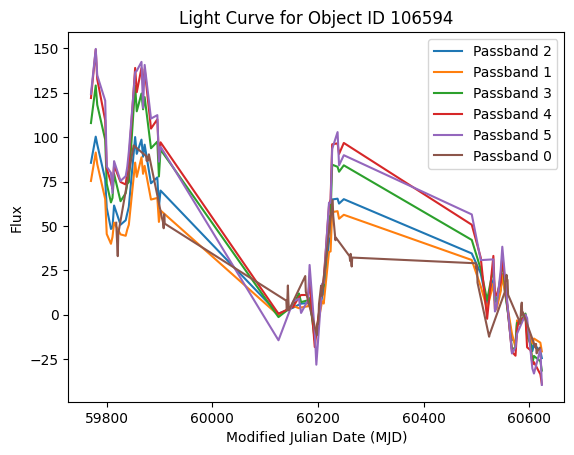

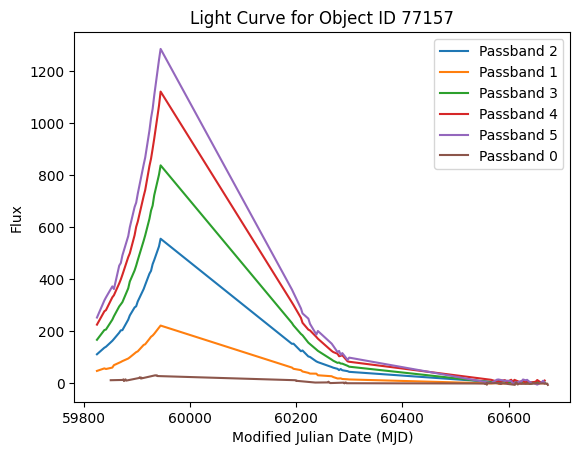

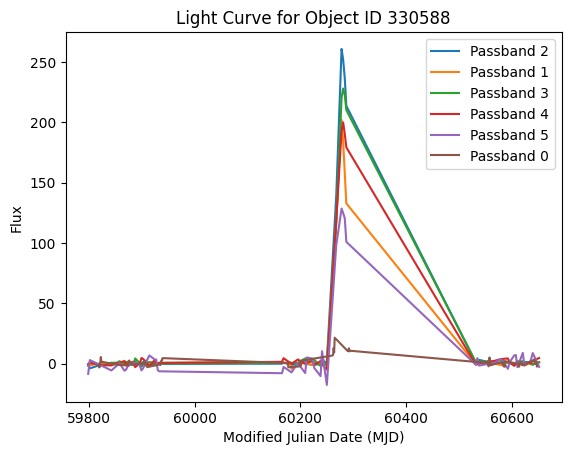

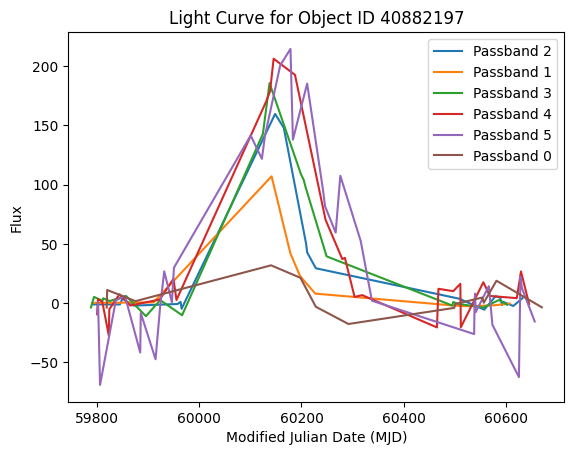

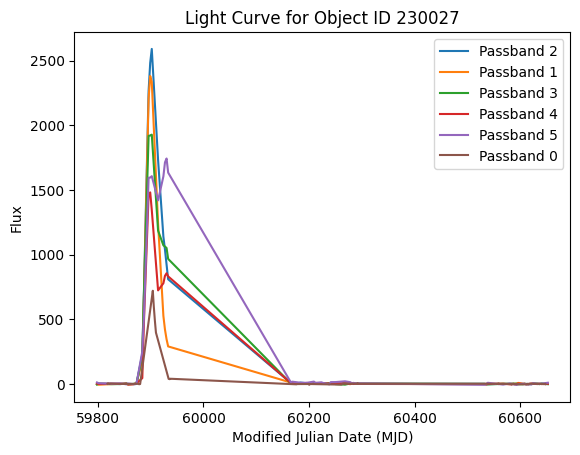

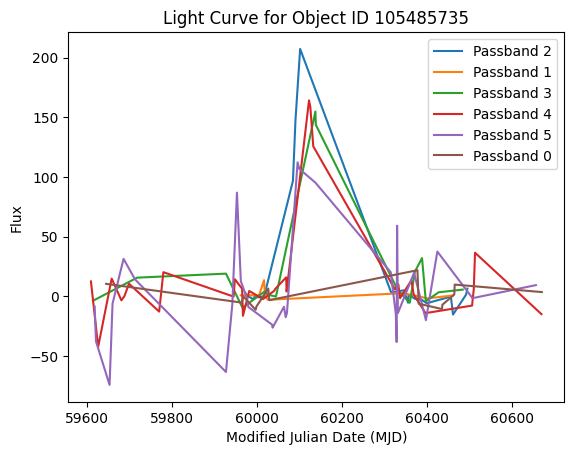

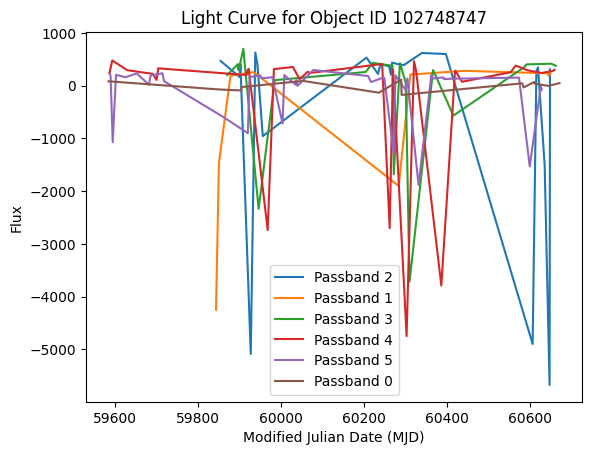

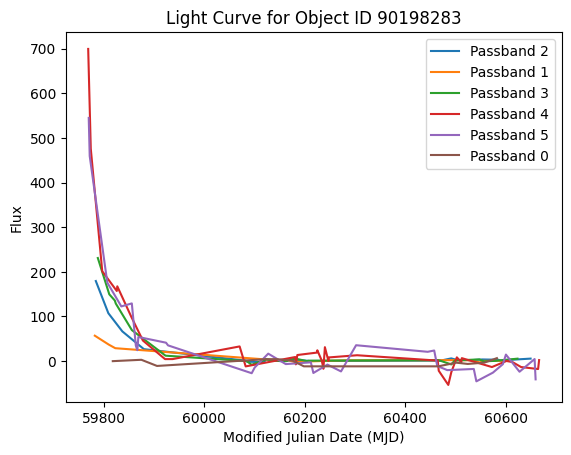

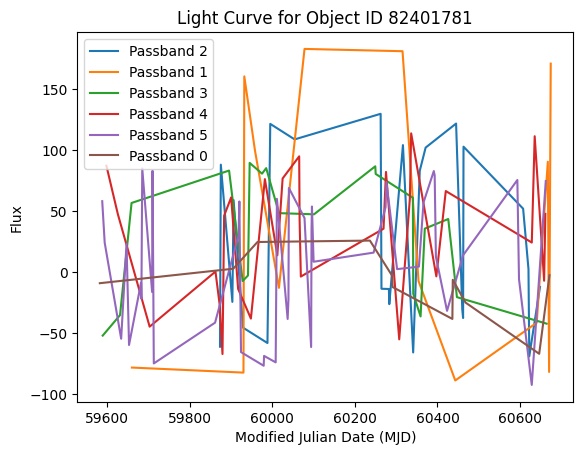

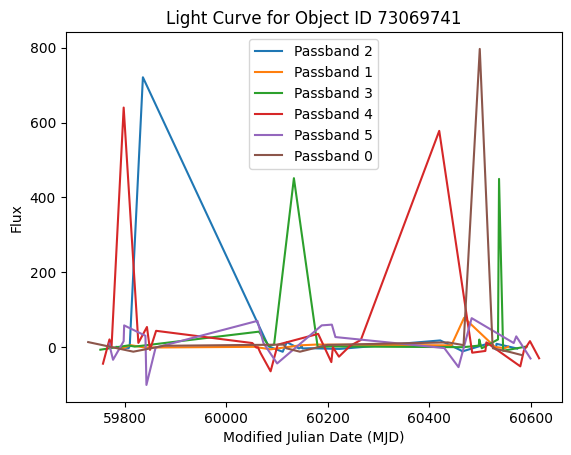

In [40]:
# Select 10 unique object IDs
object_ids = np.random.choice(objects, size=10, replace=False)

# Iterate through the selected object IDs and plot their light curves
for object_id in object_ids:
    # Filter the light curves DataFrame for the current object ID
    obj_lc = lcvs[lcvs["object_id"] == object_id]

    # Plot the light curve for each passband
    for band in bands:
        band_lc = obj_lc[obj_lc["passband"] == band]
        if not band_lc.empty:
            pl.plot(band_lc["mjd"], band_lc["flux"], label=f"Passband {band}")

    pl.xlabel("Modified Julian Date (MJD)")
    pl.ylabel("Flux")
    pl.title(f"Light Curve for Object ID {object_id}")
    pl.legend()
    pl.show()

YOUR CODE HERE...

Plot explicitly object 84716

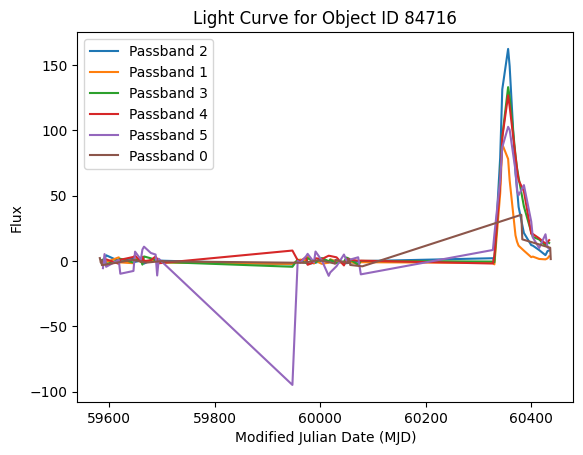

In [41]:
# Filter the light curves DataFrame for object ID 84716
obj_lc = lcvs[lcvs["object_id"] == 84716]

# Plot the light curve for each passband
for band in bands:
    band_lc = obj_lc[obj_lc["passband"] == band]
    if not band_lc.empty:
        pl.plot(band_lc["mjd"], band_lc["flux"], label=f"Passband {band}")

pl.xlabel("Modified Julian Date (MJD)")
pl.ylabel("Flux")
pl.title(f"Light Curve for Object ID 84716")
pl.legend()
pl.show()

YOUR CODE HERE

# TASK III: Extract features

Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

Extract at least 4 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

Examples of features you can extract:

- **from the original lightcurve**:
    - mean,
    - standard deviation,
    - skewness,
    - kurthosis,
    - minimum
    - maximmum,
    - error on the minimum and
    - error on the maximum,
- **from the standardized lightcurve**:
    - median
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)


Extract at least 4 features including 1 features from all three category above: original lcv, standardized lcv, metadata. Justify each feature. Coming up with different features than the ones I suggested is very welcome! Remember that if the features are extracted from the time series there will be 4 features for each passbands.

Note: we are working with bigg-ish data!
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready.
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar.


describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

### extract some features from the raw lightcurve -


higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a function call

In [42]:
#example
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()

In [43]:
#example
from scipy import stats
def m2(x):
    return stats.moment(x, moment = 2)


Even with the same standard deviation two distribution can be very different.
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties because outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation).


Standardize the lcvs and extract some features from the raw lightcurve -


You can do it use  the preprocessing.scale function and groupby, which group by object and band. It does its job, but it is slow

In [44]:
print("Mean:", mean_norm)
print("Standard Deviation:", std_norm)

NameError: name 'mean_norm' is not defined

Note: the median of the standardizeed distribution would convey the location of the "center of mass" of the data with respect to the mean


parametric features: extract some features that come from simple models of the lightcurve, e.g. line fits



the goodness of fit for these models is also a potential feature

Data Organization: you can put all your features in a dataframe using merge at each step merging each new feature with the olde ones


In [ ]:
#example
features = features.merge(....., left_index=True, right_index=True)
features.head()

means         std         s  ...     slope  intercept    a
object_id passband                                    ...                          
615       0          -3.254554   83.944735  0.125827  ...  0.000528 -31.821927 -1.0
          1        -385.699911  601.787302  0.404755  ...  0.000564 -33.921454 -1.0
          2        -134.146566  455.121346  0.331063  ...  0.000756 -45.499328 -1.0
          3        -121.103501  335.425053  0.285492  ...  0.000916 -55.091286 -1.0
          4         -55.954592  291.803449  0.194883  ...  0.001046 -62.942751 -1.0

[5 rows x 9 columns]

NOTE: when you merge the metadata features you are going to have to do some gymnastic with the indices: this is because the data has 2 indices columns: the object id and the bandpass id, while the metadata has only 1 index: the object id.

You can use the function unstuck - here is an example line of code of what worked for me **but** it kind of depends on how you organized your dataframe so this is not guaranteed to work!

In [ ]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.shape

(7848, 54)

In [ ]:
#EXAMPLE OF A POTENTIAL DATAFRAME OUTPUT
allfeatures.head()

,"(0, means)","(0, std)","(0, s)","(0, maxs)","(0, mins)","(0, medians)","(0, slope)","(0, intercept)","(0, a)","(1, means)","(1, std)","(1, s)","(1, maxs)","(1, mins)","(1, medians)","(1, slope)","(1, intercept)","(1, a)","(2, means)","(2, std)","(2, s)","(2, maxs)","(2, mins)","(2, medians)","(2, slope)","(2, intercept)","(2, a)","(3, means)","(3, std)","(3, s)","(3, maxs)","(3, mins)","(3, medians)","(3, slope)","(3, intercept)","(3, a)","(4, means)","(4, std)","(4, s)","(4, maxs)","(4, mins)","(4, medians)","(4, slope)","(4, intercept)","(4, a)","(5, means)","(5, std)","(5, s)","(5, maxs)","(5, mins)","(5, medians)","(5, slope)","(5, intercept)","(5, a)",(decl),(hostgal_photoz),(hostgal_photoz_err),(ddf),(target)
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
615,-3.254554,83.944735,0.125827,125.182808,-116.913223,-0.081180,0.000528,-31.821927,-1.0,-385.699911,601.787302,0.404755,660.626343,-1100.440063,-0.171580,0.000564,-33.921454,-1.0,-134.146566,455.121346,0.331063,611.984558,-681.858887,-0.291545,0.000756,-45.499328,-1.0,-121.103501,335.425053,0.285492,445.737061,-530.644592,-0.123500,0.000916,-55.091286,-1.0,-55.954592,291.803449,0.194883,381.953735,-422.184509,-0.164500,0.001046,-62.942751,-1.0,-47.449847,294.779522,0.121948,378.188141,-422.815094,-0.130310,0.001012,-60.907274,-1.0,-61.943836,0.0000,0.0000,1,92
713,-2.720398,7.113509,0.254446,14.509829,-14.735178,-0.053300,-0.002880,173.700723,-1.0,-1.019804,5.712334,-0.085494,9.129021,-11.715749,0.080915,-0.002824,170.138183,-1.0,-0.794238,5.770738,-0.022066,10.529041,-10.067919,0.118250,-0.002861,172.372515,-1.0,-0.986966,6.450413,-0.162664,11.330316,-12.394593,0.142830,-0.002773,167.042501,-1.0,-0.900262,6.406989,-0.062403,9.827934,-12.286801,0.017020,-0.002706,162.993030,-1.0,-1.794175,7.094073,0.212294,14.770886,-14.211164,-0.095135,-0.001996,120.260663,-1.0,-27.784405,1.6267,0.2552,1,88
730,-0.048080,1.828872,0.349431,5.942166,-3.459960,0.039740,-0.000122,7.340844,-1.0,0.141057,1.807229,0.457635,5.693109,-3.393080,0.016920,0.000341,-20.512857,-1.0,2.400870,5.559483,2.315707,20.994711,-2.848838,-0.346740,0.001740,-104.795617,1.0,3.236164,8.191987,2.584661,33.572102,-5.435799,-0.317495,0.001593,-95.949468,1.0,4.308728,10.710344,2.462542,41.159981,-5.836310,-0.311590,0.001492,-89.850962,1.0,4.539396,13.332758,1.630520,47.310059,-19.159811,-0.151250,0.001271,-76.556533,1.0,-6.579593,0.2262,0.0157,1,42
745,1.797523,4.374445,1.980815,18.014029,-3.874349,-0.170535,-0.000705,42.447482,-1.0,5.717394,25.964659,6.817994,192.244293,-3.618410,-0.187675,-0.000093,5.595442,-1.0,9.711532,31.957997,5.534683,220.795212,-2.159753,-0.293235,-0.000082,4.922653,-1.0,14.412924,34.967698,3.650356,203.250702,-4.944036,-0.376625,-0.000063,3.790789,-1.0,13.134436,33.069053,3.382600,183.633118,-15.494463,-0.362020,-0.000109,6.553614,-1.0,10.746138,26.060130,3.083716,141.513290,-10.249387,-0.309680,0.000003,-0.160795,-1.0,-45.586655,0.2813,1.1523,1,90
1124,0.660948,2.360084,-0.324207,5.330927,-6.804703,-0.034140,0.001244,-75.007738,-1.0,4.634637,8.107525,2.315295,37.170177,-2.622109,-0.432985,0.001881,-113.201612,1.0,10.243968,21.319854,2.995322,106.671692,-2.084535,-0.442620,0.001692,-101.788134,1.0,11.086555,26.270649,3.509344,139.818405,-2.800270,-0.386760,0.001465,-88.156649,1.0,9.906102,26.865913,3.802308,143.600189,-16.543753,-0.306425,0.001356,-81.569486,1.0,6.896742,21.434627,3.560347,109.157585,-10.860540,-0.231740,0.001120,-67.426967,1.0,-63.823658,0.2415,0.0176,1,90


what is the shape of your final feature space?

In [ ]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

Now make histograms for allfeatures to show their distributions

In [ ]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency')

# TASK III : Gaussian Processes

Take the time series and fit them with GPs.
- use the george package goerge (see class demo https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/GP_examples.ipynb)

- make sure you use the standardized time series : before you fit the GP to it each time series shoud be made to be mean 0 and standard deviation 1 (note - mean across all time stamps! not across all lightcurves). YOu can just do it by hand as lc /= lc.mean() or you can use `sklearn.preprocessing.StandardScaler`

- make sure you process the uncertainty as well as the data in the standardization! (divide by the same constant the lighcruve fluxes and its uncertaities)

- choose an appropriate kernel (e.g. the composite one we use in class that enables periodicity as well as stockastic variations)

- take a subset of the time series, ~10, making sure that they are of different types: the type is mapped to the metadata `target` variable

- fit the GP kernerl to each time series band by band

- collect the best fit parameters and describe their variance (across the 10 time series) `gp.get_parameter_vector()` - can all the time series be fit with the same kernel parameters? how would you initialize the fit for the whole ensamble?



# CHALLENGE (Extra Credit): fit the 2D time series:
- create a 2D array for each of the ~10 time series you used earlier: 1 dimension is time the other is wavelength (the bandpass)
- fit a 2D kernel to the time series.
- show the fits with their uncertainties marginalized along one feature at a time: the fit along the time axis for all 6 bands and the fit along the wavelength axis for a subset of the datapoints.
- (try and make a surface plot  that conveys the relevant info effectively, I find it difficult)